In [1]:
import warnings 
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

# STEP 1 -  Visualize Data

In [2]:
sales_data = pd.read_csv('data/Tractor-Sales.csv')
sales_data.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [3]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01',freq='MS',periods=len(sales_data))
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [4]:
import calendar

sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

sales_data.drop(['Month-Year'],axis=1,inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor Sales'},inplace =True)
sales_data = sales_data[['Month','Year','Tractor Sales']]
sales_data.set_index(dates,inplace=True)

sales_data.head()

,Month,Year,Tractor Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [5]:
# Extractout the timeseries
sales_ts = sales_data['Tractor Sales']
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor Sales, dtype: int64

Text(0,0.5,'Tractor Sales')

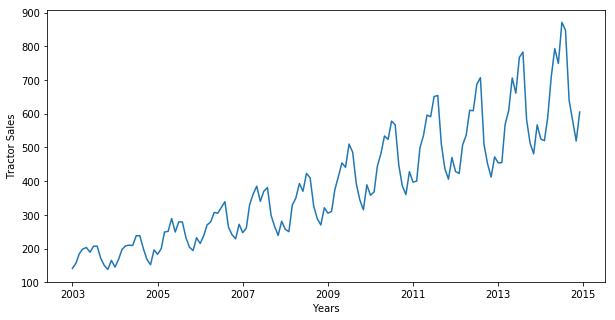

In [6]:
plt.figure(figsize=(10,5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

## Timeseries Decomposition

### Trend Extraction

It is clearly evident that there is an <b>overall increasing trend</b> in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can <b> check stationarity </b>using the following:

<b>Plotting Rolling Statistics:</b> We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

<b>Dickey-Fuller Test:</b> This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

<b><i>Moving Average</i></b> - A good analogy for moving average is <b> ironing clothes to remove wrinkles</b>. The idea with moving average is to remove all the zigzag motion (wrinkles) from the time series <b> to produce a steady trend </b>through averaging adjacent values of a time period.

Now, let’s try to remove wrinkles from our time series using moving average. We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

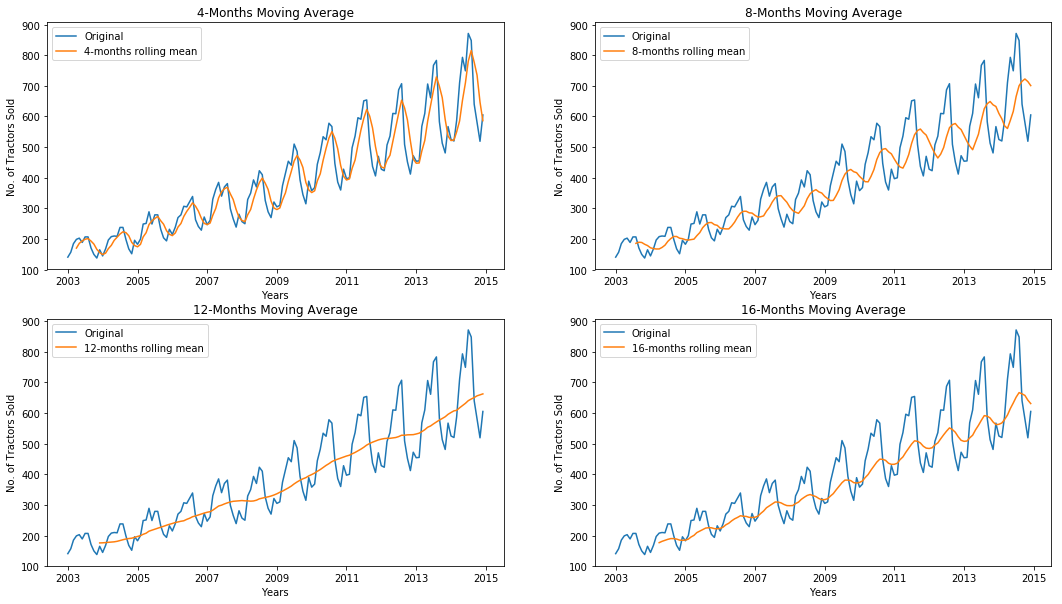

In [7]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(18)
fig.set_figheight(10)

axes[0][0].plot(sales_ts.index,sales_ts, label='Original')
axes[0][0].plot(sales_ts.index,sales_ts.rolling(window=4).mean(), label='4-months rolling mean')
axes[0][0].set_xlabel('Years')
axes[0][0].set_ylabel('No. of Tractors Sold')
axes[0][0].set_title('4-Months Moving Average')
axes[0][0].legend(loc='best')

axes[0][1].plot(sales_ts.index,sales_ts, label='Original')
axes[0][1].plot(sales_ts.index,sales_ts.rolling(window=8).mean(), label='8-months rolling mean')
axes[0][1].set_xlabel('Years')
axes[0][1].set_ylabel('No. of Tractors Sold')
axes[0][1].set_title('8-Months Moving Average')
axes[0][1].legend(loc='best')

axes[1][0].plot(sales_ts.index,sales_ts, label='Original')
axes[1][0].plot(sales_ts.index,sales_ts.rolling(window=12).mean(), label='12-months rolling mean')
axes[1][0].set_xlabel('Years')
axes[1][0].set_ylabel('No. of Tractors Sold')
axes[1][0].set_title('12-Months Moving Average')
axes[1][0].legend(loc='best')

axes[1][1].plot(sales_ts.index,sales_ts, label='Original')
axes[1][1].plot(sales_ts.index,sales_ts.rolling(window=16).mean(), label='16-months rolling mean')
axes[1][1].set_xlabel('Years')
axes[1][1].set_ylabel('No. of Tractors Sold')
axes[1][1].set_title('16-Months Moving Average')
axes[1][1].legend(loc='best')

Text(0.5,1,'Rolling Mean and Standatd Deviation')

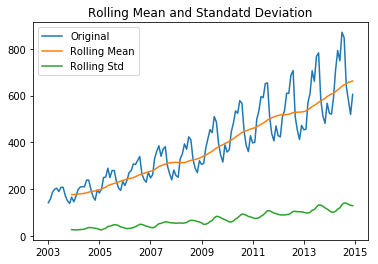

In [8]:
# Rolling Statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

# Plot Rolling Statistics
plt.plot(sales_ts,label='Original')
plt.plot(rolmean,label='Rolling Mean')
plt.plot(rolstd,label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standatd Deviation')

In [9]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print 'Result of Dickey Fuller Test'
dftest = adfuller(sales_ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Result of Dickey Fuller Test
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (5%)             -2.884219
Critical Value (1%)             -3.482088
Critical Value (10%)            -2.578864
dtype: float64


### Seasonality Extraction

In [10]:
# How number of tractors sold vary on a month on month basis ?
monthly_sales_data = pd.pivot_table(sales_data, values='Tractor Sales',columns='Year', index='Month')
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


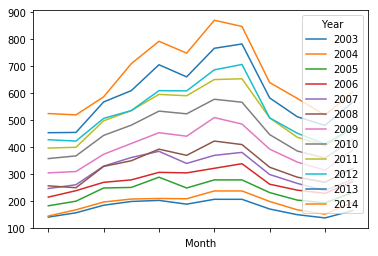

In [11]:
monthly_sales_data.plot()

In [12]:
yearly_sales_data = pd.pivot_table(sales_data,values='Tractor Sales',columns='Month',index='Year')
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


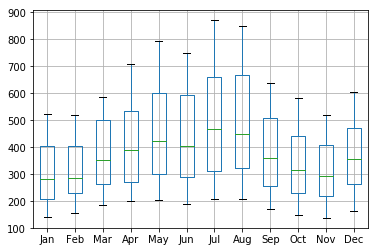

In [13]:
yearly_sales_data.boxplot()

<b>Important Inferences</b>

    1. The tractor sales have been increasing without fail every year.
    2. July and August are the peak months for tractor sales and the variance and the mean value in July and August are also 
       much higher than any of the other months.
    3.We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the
     beginning of the year and drops down towards the end of the year.We can see a seasonal effect with a cycle of 12 months

### Irregular Component Extraction

In [14]:
decompositions = sm.tsa.seasonal_decompose(sales_ts,model='multiplicative')

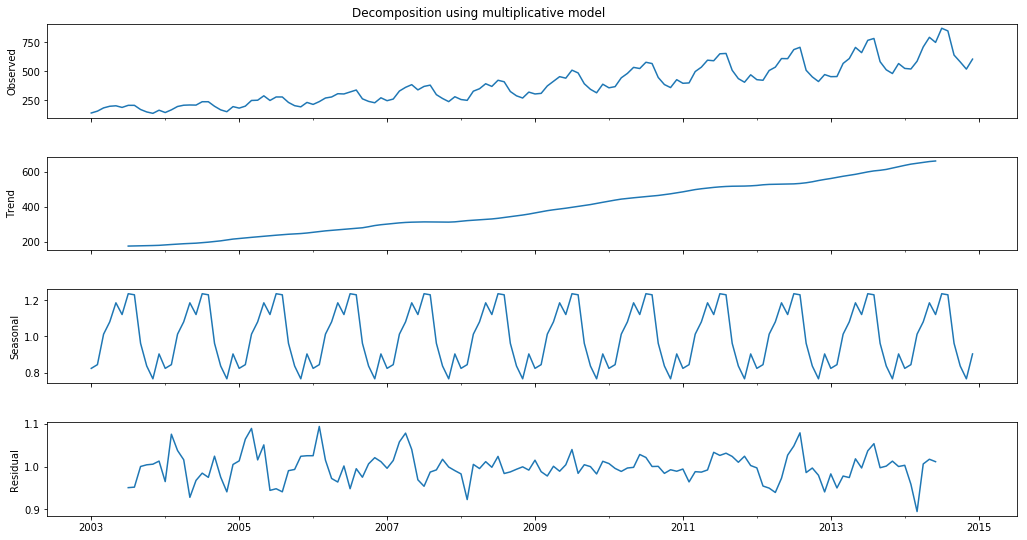

In [15]:
fig = decompositions.plot()
fig.set_figwidth(16)
fig.set_figheight(8)
fig.suptitle('Decomposition using multiplicative model')
plt.show()

## ARIMA MODELING

ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all).

<b> Integrated (I) </b> – Subtract time series with its lagged series to extract trends from the data.

<b> AutoRegressive (AR) </b> – Extract the influence of the previous periods’ values on the current period.
As the name auto-regression suggests, here we try to extract the influence of the values of previous periods on the current period.

<b> Moving Average (MA) </b> – Extract the influence of the previous period’s error terms on the current period’s error.
MA involves finding relationships between the previous periods' error terms on the current period's error term. Keep in mind, this moving average (MA) has nothing to do with moving average we learned about in the previous article on time series decomposition.

## White Noise

White noise is a funny thing, if we look at it for long we will start seeing some false patterns. This is because the human brain is wired to find patterns, and at times confuses noises with signals.
This is precisely the reason why we need a mathematical or logical process to distinguish between a white noise and a signal (juice / information).
A good way to distinguish between signal and noise is ACF (AutoCorrelation Function). This is developed by finding the correlation between a series of its lagged values.

# STEP 2 : Difference Data to make data stationary on mean (Remove Trend)

Text(0,0.5,'Tractor Sales')

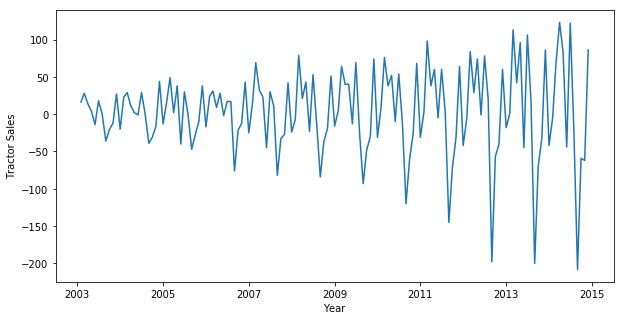

In [22]:
plt.figure(figsize=(10,5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Year')
plt.ylabel('Tractor Sales')

# STEP 4 - Log Transform data to make stationary on varinace

Text(0,0.5,'Log(Tractor_sales)')

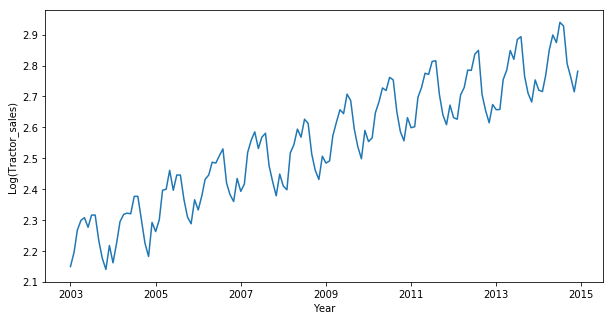

In [24]:
plt.figure(figsize=(10,5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Year')
plt.ylabel('Log(Tractor_sales)')

# STEP 4 : Difference Log Transform data to make it stationary on mean and varinace

Text(0,0.5,'Differenced Log (Tractor_Sales)')

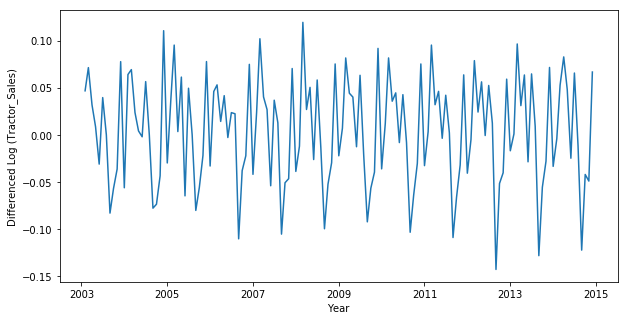

In [28]:
plt.figure(figsize=(10,5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Year')
plt.ylabel('Differenced Log (Tractor_Sales)')

# STEP 5 : Plot ACF and PACF to identify potential AR and MA model

The idea is to identify presence of AR and MA components in the residuals.

In [29]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1)
sales_ts_log_diff.dropna(inplace=True)

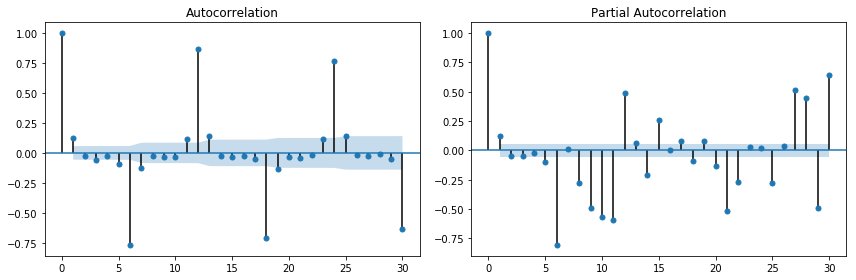

In [34]:
fig, axes = plt.subplots(1,2,sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff,lags=30,ax=axes[0],alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff,lags=30,ax=axes[1],alpha=0.5)
plt.tight_layout()

# STEP 6 - Identification of Best Fit ARIMA Model

In [44]:
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))

# Genrate all different combinations of seasonal p,d and q tiplets
seasonal_pdq = [(x[0],x[1],x[2],12)for x in pdq]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [48]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log, order=param, seasonal_order=seasonal_param, enforce_stationarity=True, enforce_invertibility=True)
            results = temp_model.fit()
            
            if(results.aic < best_aic):
                
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
        
        except:
            continue


print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.774586757


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Akaike Information Criterion (AIC)

AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

AIC=2K−2ln(L) 

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

# STEP 8 : Predict Sales on in-sample date using best fit ARIMA model

In [50]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,order=best_pdq,seasonal_order=best_seasonal_pdq,enforce_stationarity=True,enforce_invertibility=True)
best_results = best_model.fit()

In [56]:
print best_results.summary().tables[0]
print best_results.summary().tables[1]

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor Sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Mon, 21 May 2018   AIC                           -733.775
Time:                                    15:21:41   BIC                           -721.923
Sample:                                01-01-2003   HQIC                          -728.959
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3576      0.069     -5.201      0.000      -0.492      -0.223
ar.S.L12       0.9933      0.006   

In [57]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'),dynamic=True,full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [60]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

mse = ((sales_ts_forecasted-sales_ts_truth)**2).mean()
print ('The mean squared error of our forecast is {}'.format(round(mse,4)))

The mean squared error of our forecast is 0.0011


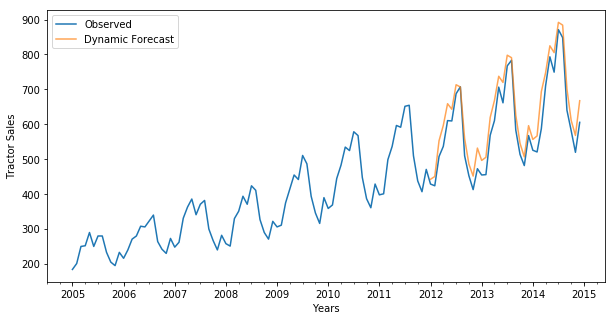

In [66]:
axis = sales_ts['2005':].plot(label='Observed',figsize=(10,5))
np.power(10,pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')

# Forecast Sale using best fit ARIMA model

In [72]:
# Get a forecast of 3 years ahead
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 signifies 95% confidence interval

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [79]:
idx = pd.date_range(sales_ts.index[-1], periods=36, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10,pred_uc_95.predicted_mean), np.power(10,pred_ci_95)]), index=idx, columns=['forecast','lower_ci_95','upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10,pred_uc_99.predicted_mean), np.power(10,pred_ci_99)]), index=idx, columns=['forecast','lower_ci_99','upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.464720,528.226997,609.617096,528.226997,609.617096
2015-01-01,566.211936,519.987702,616.545268,519.987702,616.545268
2015-02-01,668.859785,607.145193,736.847492,607.145193,736.847492
2015-03-01,755.214536,678.449115,840.665840,678.449115,840.665840
2015-04-01,850.232041,756.613109,955.434837,756.613109,955.434837


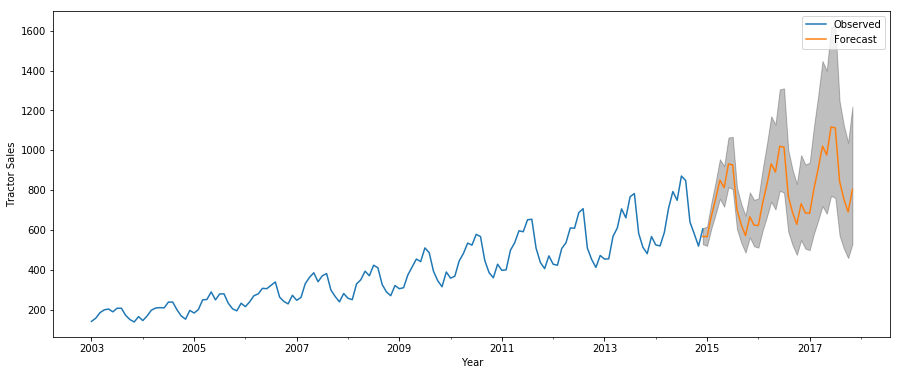

In [94]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed',figsize=(15, 6))
fc_all['forecast'].plot(ax=axis,label='Forecast')
axis.fill_between(fc_all.index, fc_all['lower_ci_95'],fc_all['upper_ci_95'],color='k',alpha=0.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'],fc_all['upper_ci_99'],color='k',alpha=0.5)
axis.set_xlabel('Year')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')

# STEP 8 - Plot ACF and PACF of residuals of arima model to ensure no more information is left for extraction

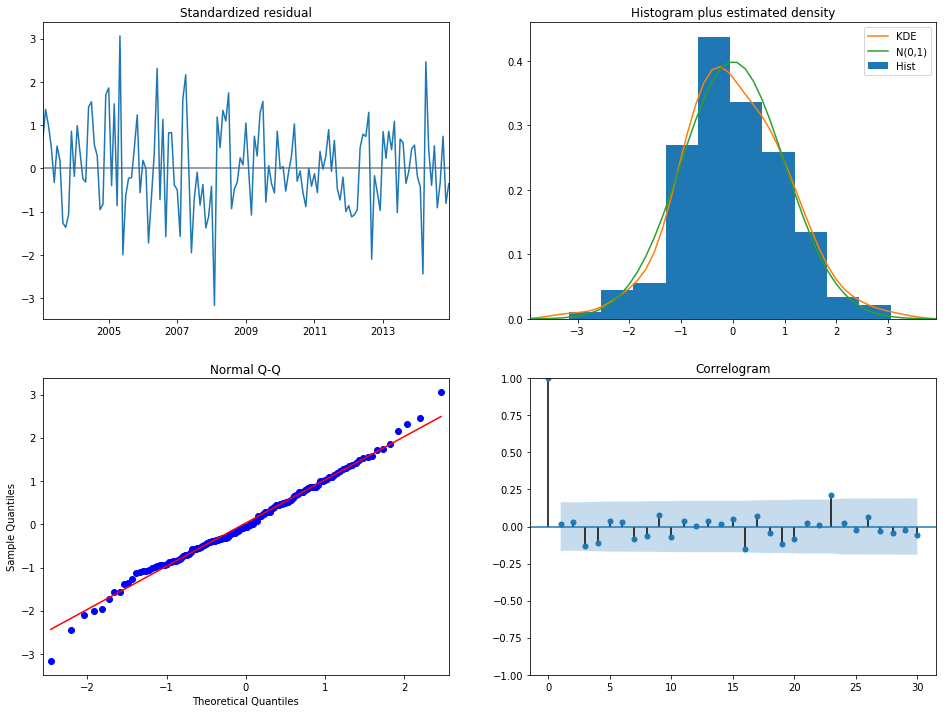

In [96]:
best_results.plot_diagnostics(lags=30,figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

    The KDE plot of the residuals on the top right is almost similar with the normal distribution.
    
    The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of 
    the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the
    residuals are normally distributed.
    
    The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is 
    confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals 
    have low correlation with lagged versions of itself.
